# Libraries

In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis import align
import MDAnalysis.analysis.rms as rms
import matplotlib.pyplot as plt
import numpy as np
import math
import glob as g
import seaborn as sns
from tqdm import tqdm
bar_format_str = '{l_bar}{bar:20}{r_bar}{bar:-20b}'

/Users/jhenderson/Software/anaconda3/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib
/Users/jhenderson/Software/anaconda3/lib/python3.11/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


Warnings Ignored: 1.) Atom types missing masses, 2.) Some atom types missing elemental information, 3.) Missing resid information is be reset to one (this is likely water information), 4.) np.int deprecation warning. These errors tend to happen when converting Desmond trajectories to DCD. 

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

# Define Metrics for the IN and Out states

In [4]:
In_State  = "REF_Structures/WT-IH_B-Series_wt_numbering.pdb"
Out_State = "REF_Structures/1kxx_C-Helix_out_wt_numbering.pdb"

In [5]:
u_in  = mda.Universe(In_State)
u_out = mda.Universe(Out_State) 

Get the In-State Vector

In [6]:
p1_in = u_in.select_atoms("resid 755 756 757 758 and name CA")
p2_in = u_in.select_atoms("resid 765 766 767 768 and name CA")
p1_in_c = p1_in.center_of_mass()
p2_in_c = p2_in.center_of_mass()
vec_i = [p1_in_c[0] - p2_in_c[0], p1_in_c[1] - p2_in_c[1], p1_in_c[2] - p2_in_c[2]]
#print(vec_i)

Get the Out-State Vector

In [7]:
p1_out = u_out.select_atoms("resid 755 756 757 758 and name CA")
p2_out = u_out.select_atoms("resid 765 766 767 768 and name CA")
p1_out_c = p1_out.center_of_mass()
p2_out_c = p2_out.center_of_mass()
vec_o = [p1_out_c[0] - p2_out_c[0], p1_out_c[1] - p2_out_c[1], p1_out_c[2] - p2_out_c[2]]
#print(vec_o)

Calculate the Angle between the two vectors.

In [8]:
angle_in_rad = angle_between(vec_i, vec_o)
angle_in_deg = math.degrees(angle_in_rad)
in_state_difference = angle_in_deg
print(in_state_difference)

26.57054722967854


# Perform Analysis

The following reference structure is the same as the PDB but the duplicate residue positions have been removed. They were removed based on the Maestro's selection. 

In [9]:
chelix_out_WT  = g.glob(f'REF_Structures/1kxx_C-Helix_out_wt_numbering.pdb')[0]
chelix_out_MUT = g.glob(f'REF_Structures/1kxx_C-Helix_out_mut_numbering.pdb')[0]
chelix_in_WT  = g.glob(f'REF_Structures/WT-IH_B-Series_wt_numbering.pdb')[0]
chelix_in_MUT = g.glob(f'REF_Structures/WT-IH_B-Series_mut_numbering.pdb')[0]
systems = ['WT','NPG','ASV','SVD']
replicas = [1,2,3,4,5]

In [10]:
out_data  = [] # (RMSD wrt Out and Angle betwen Mobile and C-Helix Out State)
in_data   = [] # (RMSD wrt In) 
for sys in systems:
    for rep in replicas:
        print(f'Working on System {sys} Run {rep}.')
        parm = g.glob(f'../data/{sys}_{rep}/init.pdb')[0]
        dcd  = g.glob(f'../data/{sys}_{rep}/converted.dcd')[0]
        u = mda.Universe(parm, dcd, in_memory=True, in_memory_step=1) # Becareful to Change This
        chelix_out_ref_WT  = mda.Universe(chelix_out_WT)
        chelix_out_ref_MUT = mda.Universe(chelix_out_MUT) 
        chelix_in_ref_WT  = mda.Universe(chelix_in_WT)
        chelix_in_ref_MUT = mda.Universe(chelix_in_MUT) 

        prot_chainID = list(set(u.select_atoms("protein").chainIDs))[0]
        
        # Selection got Alignment 
        # This alignment only covers the non-missing regions of 1kxx and excludes the C-Helix.
        wt_mobile_sele      = f"name CA and resid 702:733 738:749 777:866 876:984"
        mut_mobile_sele     = f"name CA and resid 702:733 738:749 780:869 879:987"
        
        #-------------------------------------------#
        # Step 1: Out State Reference Calculations  #
        #-------------------------------------------#
        print("--- Performing Alignment (Out-State Reference Step)")
        if 'WT' in sys:
            align.AlignTraj(u, chelix_out_ref_WT, select=f"{wt_mobile_sele}",in_memory=True).run()
        else:
            align.AlignTraj(u, chelix_out_ref_MUT, select=f"{mut_mobile_sele}",in_memory=True).run()
    
        # Calculate the RMSD of the C-Helix and the Angle between the Mobile C-Helix and the Static C-Helix
        # of the out-state PDB 1kxx.
        # RMSD out_data: Alpha Carbons for the C-Helix
        a_1 = u.select_atoms("name CA and resid 755:763")
        a_2 = u.select_atoms("name CA and resid 764:769")
        a = a_1 + a_2 # This fixes a weird maestro bug.
        b_out = chelix_out_ref_WT.select_atoms(f"chainID Y and name CA and resid 755:769")
        out_data_sub = []
        for ts in tqdm(u.trajectory, bar_format=bar_format_str):
            r = rms.rmsd(a.positions, b_out.positions, center=False, superposition=False)
            # Define the Vector of the Mobile C-Helix for the simulations.
            p1_u = u.select_atoms("resid 755 756 757 758 and name CA")
            p2_u = u.select_atoms("resid 765 766 767 768 and name CA")
            p1_u_c = p1_u.center_of_mass()
            p2_u_c = p2_u.center_of_mass()
            vec_u = [p1_u_c[0] - p2_u_c[0], p1_u_c[1] - p2_u_c[1], p1_u_c[2] - p2_u_c[2]]
            angle_in_rad = angle_between(vec_u, vec_o)
            angle_in_deg = math.degrees(angle_in_rad)
            out_data_sub.append([r, angle_in_deg])
        out_data.append(out_data_sub)
        
        #-------------------------------------------#
        # Step 2: In State Reference Calculations   #
        #-------------------------------------------#
        print("--- Performing Alignment (In-State Reference Step)")
        if 'WT' in sys:
            align.AlignTraj(u, chelix_in_ref_WT, select=f"{wt_mobile_sele}",in_memory=True).run()
        else:
            align.AlignTraj(u, chelix_in_ref_MUT, select=f"{mut_mobile_sele}",in_memory=True).run() 
        
        b_in = chelix_in_ref_WT.select_atoms(f"name CA and resid 755:769") 
        in_data_sub = []
        for ts in tqdm(u.trajectory, bar_format=bar_format_str):
            # Alignment is already complete so center and superposition are set to false
            r = rms.rmsd(a.positions, b_in.positions, center=False, superposition=False)
            in_data_sub.append(r)
        in_data.append(in_data_sub)

Working on System WT Run 1.
--- Performing Alignment (Out-State Reference Step)


100%|████████████████████| 1502/1502 [00:04<00:00, 314.88it/s]                                                                                                                                                      


--- Performing Alignment (In-State Reference Step)


100%|████████████████████| 1502/1502 [00:00<00:00, 111840.16it/s]                                                                                                                                                   


Working on System WT Run 2.
--- Performing Alignment (Out-State Reference Step)


100%|████████████████████| 1502/1502 [00:04<00:00, 315.68it/s]                                                                                                                                                      


--- Performing Alignment (In-State Reference Step)


100%|████████████████████| 1502/1502 [00:00<00:00, 114638.51it/s]                                                                                                                                                   


Working on System WT Run 3.
--- Performing Alignment (Out-State Reference Step)


100%|████████████████████| 1502/1502 [00:04<00:00, 323.69it/s]                                                                                                                                                      


--- Performing Alignment (In-State Reference Step)


100%|████████████████████| 1502/1502 [00:00<00:00, 118129.47it/s]                                                                                                                                                   


Working on System WT Run 4.
--- Performing Alignment (Out-State Reference Step)


100%|████████████████████| 1502/1502 [00:04<00:00, 321.52it/s]                                                                                                                                                      


--- Performing Alignment (In-State Reference Step)


100%|████████████████████| 1502/1502 [00:00<00:00, 115288.86it/s]                                                                                                                                                   


Working on System WT Run 5.
--- Performing Alignment (Out-State Reference Step)


100%|████████████████████| 1502/1502 [00:04<00:00, 323.18it/s]                                                                                                                                                      


--- Performing Alignment (In-State Reference Step)


100%|████████████████████| 1502/1502 [00:00<00:00, 117387.68it/s]                                                                                                                                                   


Working on System NPG Run 1.
--- Performing Alignment (Out-State Reference Step)


100%|████████████████████| 1502/1502 [00:04<00:00, 313.27it/s]                                                                                                                                                      


--- Performing Alignment (In-State Reference Step)


100%|████████████████████| 1502/1502 [00:00<00:00, 114291.19it/s]                                                                                                                                                   


Working on System NPG Run 2.
--- Performing Alignment (Out-State Reference Step)


100%|████████████████████| 1502/1502 [00:04<00:00, 321.53it/s]                                                                                                                                                      


--- Performing Alignment (In-State Reference Step)


100%|████████████████████| 1502/1502 [00:00<00:00, 115948.77it/s]                                                                                                                                                   


Working on System NPG Run 3.
--- Performing Alignment (Out-State Reference Step)


100%|████████████████████| 1502/1502 [00:04<00:00, 323.61it/s]                                                                                                                                                      


--- Performing Alignment (In-State Reference Step)


100%|████████████████████| 1502/1502 [00:00<00:00, 114011.96it/s]                                                                                                                                                   


Working on System NPG Run 4.
--- Performing Alignment (Out-State Reference Step)


100%|████████████████████| 1502/1502 [00:04<00:00, 323.68it/s]                                                                                                                                                      


--- Performing Alignment (In-State Reference Step)


100%|████████████████████| 1502/1502 [00:00<00:00, 113580.29it/s]                                                                                                                                                   


Working on System NPG Run 5.
--- Performing Alignment (Out-State Reference Step)


100%|████████████████████| 1502/1502 [00:04<00:00, 323.73it/s]                                                                                                                                                      


--- Performing Alignment (In-State Reference Step)


100%|████████████████████| 1502/1502 [00:00<00:00, 106443.26it/s]                                                                                                                                                   


Working on System ASV Run 1.
--- Performing Alignment (Out-State Reference Step)


100%|████████████████████| 1502/1502 [00:04<00:00, 307.67it/s]                                                                                                                                                      


--- Performing Alignment (In-State Reference Step)


100%|████████████████████| 1502/1502 [00:00<00:00, 117186.79it/s]                                                                                                                                                   


Working on System ASV Run 2.
--- Performing Alignment (Out-State Reference Step)


100%|████████████████████| 1502/1502 [00:04<00:00, 320.26it/s]                                                                                                                                                      


--- Performing Alignment (In-State Reference Step)


100%|████████████████████| 1502/1502 [00:00<00:00, 120306.40it/s]                                                                                                                                                   


Working on System ASV Run 3.
--- Performing Alignment (Out-State Reference Step)


100%|████████████████████| 1502/1502 [00:04<00:00, 309.84it/s]                                                                                                                                                      


--- Performing Alignment (In-State Reference Step)


100%|████████████████████| 1502/1502 [00:00<00:00, 118853.78it/s]                                                                                                                                                   


Working on System ASV Run 4.
--- Performing Alignment (Out-State Reference Step)


100%|████████████████████| 1502/1502 [00:04<00:00, 319.20it/s]                                                                                                                                                      


--- Performing Alignment (In-State Reference Step)


100%|████████████████████| 1502/1502 [00:00<00:00, 109499.67it/s]                                                                                                                                                   


Working on System ASV Run 5.
--- Performing Alignment (Out-State Reference Step)


100%|████████████████████| 1502/1502 [00:04<00:00, 320.85it/s]                                                                                                                                                      


--- Performing Alignment (In-State Reference Step)


100%|████████████████████| 1502/1502 [00:00<00:00, 117444.58it/s]                                                                                                                                                   


Working on System SVD Run 1.
--- Performing Alignment (Out-State Reference Step)


100%|████████████████████| 1502/1502 [00:04<00:00, 323.78it/s]                                                                                                                                                      


--- Performing Alignment (In-State Reference Step)


100%|████████████████████| 1502/1502 [00:00<00:00, 116568.81it/s]                                                                                                                                                   


Working on System SVD Run 2.
--- Performing Alignment (Out-State Reference Step)


100%|████████████████████| 1502/1502 [00:04<00:00, 321.20it/s]                                                                                                                                                      


--- Performing Alignment (In-State Reference Step)


100%|████████████████████| 1502/1502 [00:00<00:00, 113547.54it/s]                                                                                                                                                   


Working on System SVD Run 3.
--- Performing Alignment (Out-State Reference Step)


100%|████████████████████| 1502/1502 [00:04<00:00, 313.11it/s]                                                                                                                                                      


--- Performing Alignment (In-State Reference Step)


100%|████████████████████| 1502/1502 [00:00<00:00, 111531.28it/s]                                                                                                                                                   


Working on System SVD Run 4.
--- Performing Alignment (Out-State Reference Step)


100%|████████████████████| 1502/1502 [00:04<00:00, 322.33it/s]                                                                                                                                                      


--- Performing Alignment (In-State Reference Step)


100%|████████████████████| 1502/1502 [00:00<00:00, 113814.22it/s]                                                                                                                                                   


Working on System SVD Run 5.
--- Performing Alignment (Out-State Reference Step)


100%|████████████████████| 1502/1502 [00:04<00:00, 320.60it/s]                                                                                                                                                      


--- Performing Alignment (In-State Reference Step)


100%|████████████████████| 1502/1502 [00:00<00:00, 117694.71it/s]                                                                                                                                                   


Save Data

This will save the data formatted as RMSD-wrt-Out, RMSD-wrt-IN, Angle for each system and replicate. 

In [11]:
index = 0 
for sys in systems:
    for rep in replicas:
        with open(f'C-Helix_Transition_Data/{sys}_{rep}_rmsd_and_angle_ts.dat','w') as o:
            for dat1, dat2 in zip(out_data[index][1:], in_data[index][1:]) :
                o.write(f"{dat1[0]:0.2f} {dat2:0.2f} {dat1[1]:0.2f}\n")
        index += 1

# Plotting the RMSD

In [12]:
sns.set_theme(style="ticks")

## RMSD Timeseries for C-Helix (wrt Out State) - Extended Data Figure 1A

This is the key figure showing that the C-Helix, having starting from the In-State, has moved close in position to the out-state crystal structure. Colors are red, yellow, and green, for in-state, intermediate-state, and out-state, respectivily.

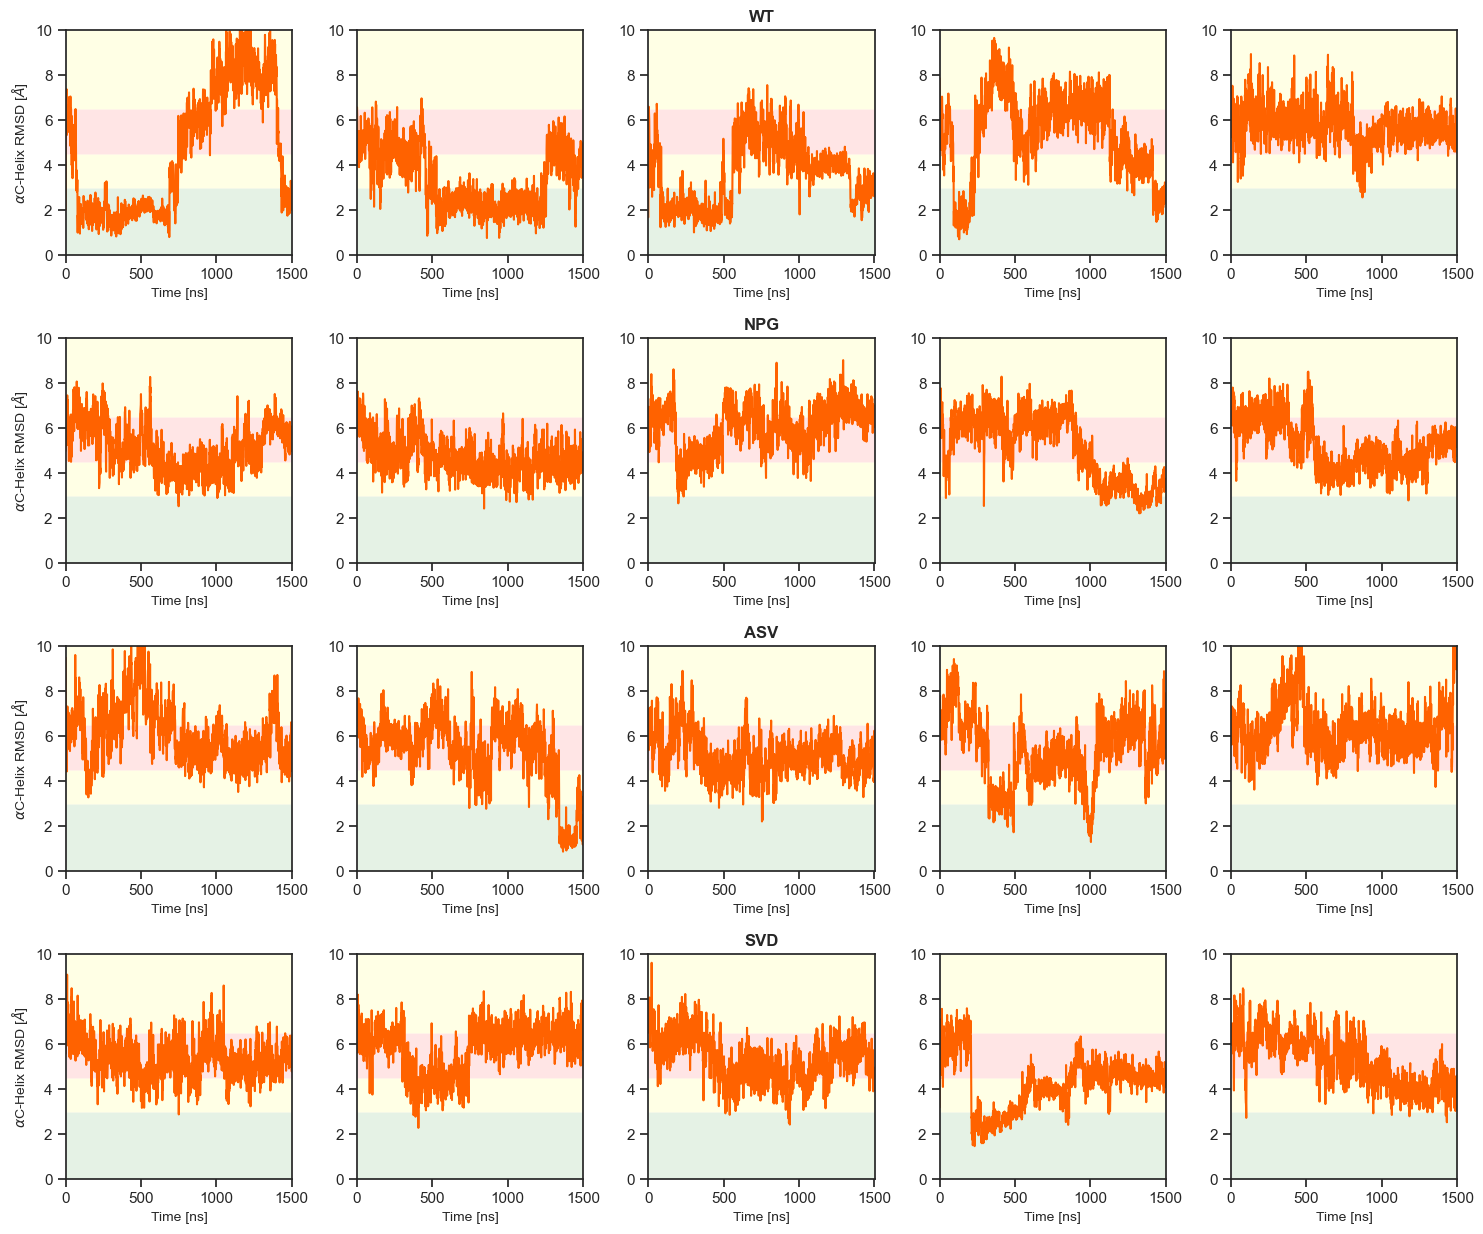

In [13]:
# fold
cols = 5
rows = len(systems)
fig, ax = plt.subplots(rows, cols, figsize=(15, 12.5)) #(15, 12.5)
ax = ax.flatten()

title_spots = [2, 7, 12, 17, 22]
flag = 0
for n in range(cols*rows):
    if n < len(out_data):
        ax[n].plot([x/1 for x in range(len(out_data[n]))], [x[0] for x in out_data[n]], color='#FF6200')
        ax[n].axhspan(0, 3, facecolor='green', alpha=0.1) # Out-State Conformation
        ax[n].axhspan(3, 4.5, facecolor='yellow', alpha=0.1) # Intermediate-State Conformation
        ax[n].axhspan(4.5, 6.5, facecolor='red', alpha=0.1) # In-State Conformation
        ax[n].axhspan(6.5, 10, facecolor='yellow', alpha=0.1) # Intermediate-State Conformation
    
        if n in title_spots:
            ax[n].set_title(f'{systems[flag]}',fontsize=12, weight='bold')
            flag += 1
        if (n+5)%5 == 0:
            ax[n].set_ylabel(r'$\alpha$C-Helix RMSD [$\AA$]',fontsize=10)
        #if n > (cols*rows-6):
        ax[n].set_xlabel('Time [ns]',fontsize=10)
        
        ax[n].set_xlim(0, len(out_data[n])/1)
        ax[n].set_ylim(0, 10)
        #ax[n].set_xlim(-50, len(out_data[n]))
        #ax[n].spines['right'].set_visible(False)
        #ax[n].spines['top'].set_visible(False)
        
    else: 
        ax[n].remove()
    
plt.tight_layout()
plt.savefig('plots/Extended_Data_Fig_1A.pdf', dpi=600)

## RMSD Timeseries for C-Helix (wrt In State)

This plot is a nice sanity check to show the C-Helix RMSD is moving away from the intial state through an intermediate state into the out-state. This plot helps more clearly show the intermediate state. 

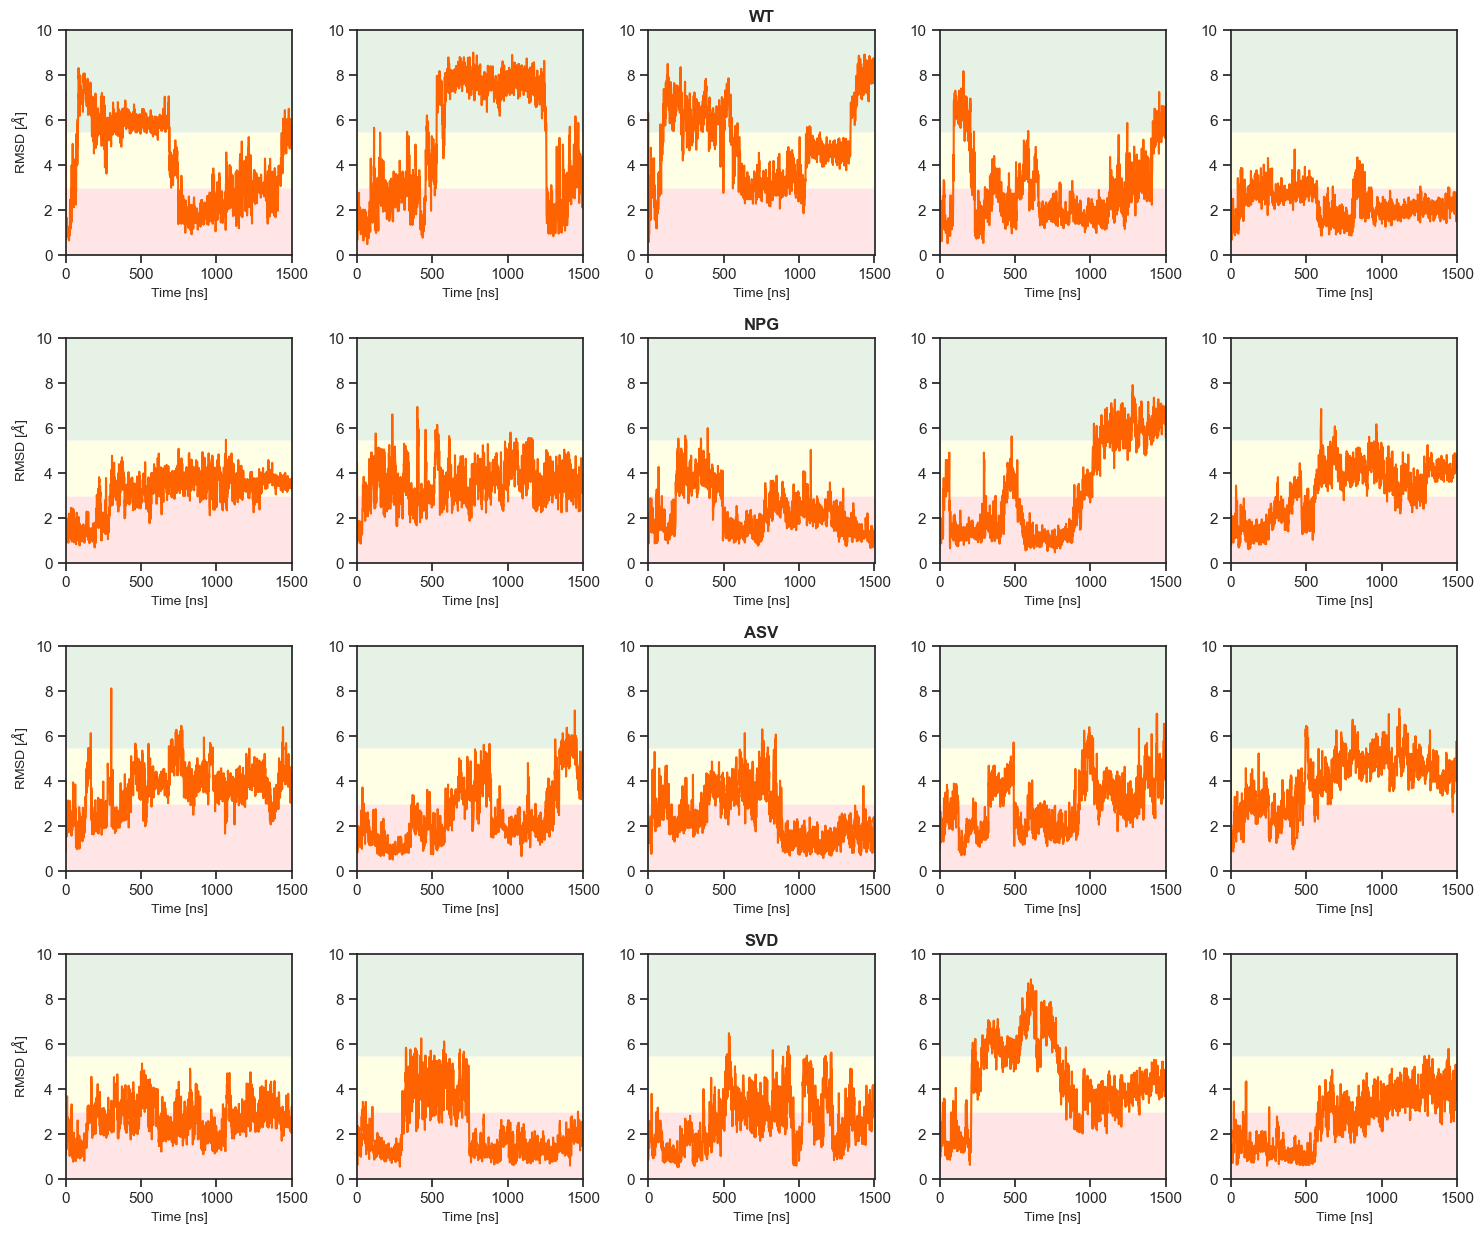

In [14]:
# fold
cols = 5
rows = len(systems)
fig, ax = plt.subplots(rows, cols, figsize=(15, 12.5)) #(15, 12.5)
ax = ax.flatten()

title_spots = [2, 7, 12, 17, 22]
flag = 0
for n in range(cols*rows):
    if n < len(in_data):
        ax[n].plot([x/1 for x in range(len(in_data[n]))], in_data[n], color='#FF6200')
        ax[n].axhspan(0, 3, facecolor='red', alpha=0.1)
        ax[n].axhspan(3, 5.5, facecolor='yellow', alpha=0.1)
        ax[n].axhspan(5.5, 10, facecolor='green', alpha=0.1)
        
        
    
        if n in title_spots:
            ax[n].set_title(f'{systems[flag]}',fontsize=12, weight='bold')
            flag += 1
        if (n+5)%5 == 0:
            ax[n].set_ylabel('RMSD [$\AA$]',fontsize=10)
        #if n > (cols*rows-6):
        ax[n].set_xlabel('Time [ns]',fontsize=10)
        
        ax[n].set_xlim(0, len(in_data[n])/1)
        ax[n].set_ylim(0, 10)
        #ax[n].set_xlim(-50, len(in_data[n]))
        #ax[n].spines['right'].set_visible(False)
        #ax[n].spines['top'].set_visible(False)
        
    else: 
        ax[n].remove()
    
plt.tight_layout()
#plt.savefig('RMSD_wrt_C-Helix_Out_MetaD.png', dpi=360)

#  C-Helix Angle Analysis

Measuring the angle between the C-Helix in the simulation with respect to the C-Helix out crystal structure helps reinforce the idea that transition from in-to-out are really only consitentaly being seen in the WT system. 

## Angle Timeseries for C-Helix

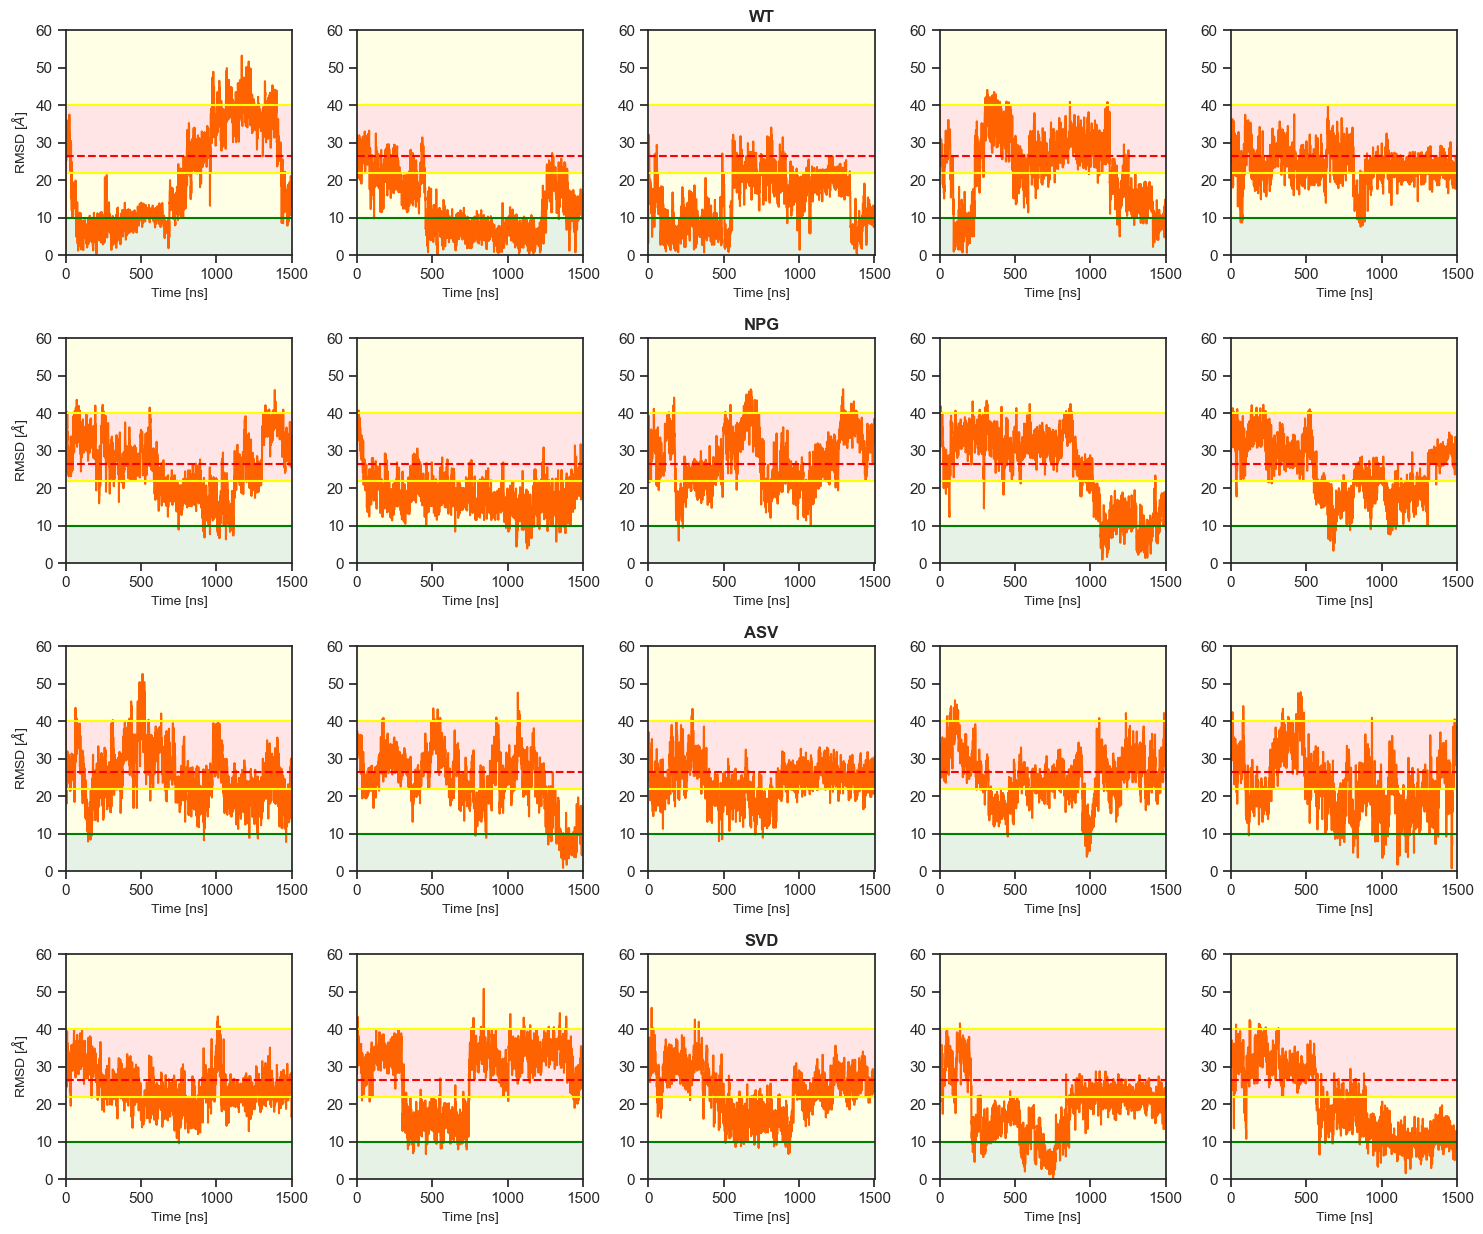

In [15]:
# fold
cols = 5
rows = len(systems)
fig, ax = plt.subplots(rows, cols, figsize=(15, 12.5)) #(15, 12.5)
ax = ax.flatten()

title_spots = [2, 7, 12, 17, 22]
flag = 0
for n in range(cols*rows):
    if n < len(out_data):
        ax[n].plot([x/1 for x in range(len(out_data[n]))], [x[1] for x in out_data[n]], color='#FF6200')
        ax[n].hlines(in_state_difference, 0, len(out_data[n]), color="red", linestyle="dashed")
        ax[n].hlines(40, 0, len(out_data[n]), color="yellow", linestyle="solid")
        ax[n].hlines(22, 0, len(out_data[n]), color="yellow", linestyle="solid")
        ax[n].hlines(10, 0, len(out_data[n]), color="green")
        
        ax[n].axhspan(0, 10, facecolor='green', alpha=0.1)
        ax[n].axhspan(10, 22, facecolor='yellow', alpha=0.1)
        ax[n].axhspan(22, 40, facecolor='red', alpha=0.1)
        ax[n].axhspan(40, 60, facecolor='yellow', alpha=0.1)
    
        if n in title_spots:
            ax[n].set_title(f'{systems[flag]}',fontsize=12, weight='bold')
            flag += 1
        if (n+5)%5 == 0:
            ax[n].set_ylabel('RMSD [$\AA$]',fontsize=10)
        #if n > (cols*rows-6):
        ax[n].set_xlabel('Time [ns]',fontsize=10)
        
        ax[n].set_xlim(0, len(out_data[n])/1)
        ax[n].set_ylim(0, 60)
        #ax[n].set_xlim(-50, len(out_data[n]))
        #ax[n].spines['right'].set_visible(False)
        #ax[n].spines['top'].set_visible(False)
        
    else: 
        ax[n].remove()
    
plt.tight_layout()

## Angle Histogram for C-Helix

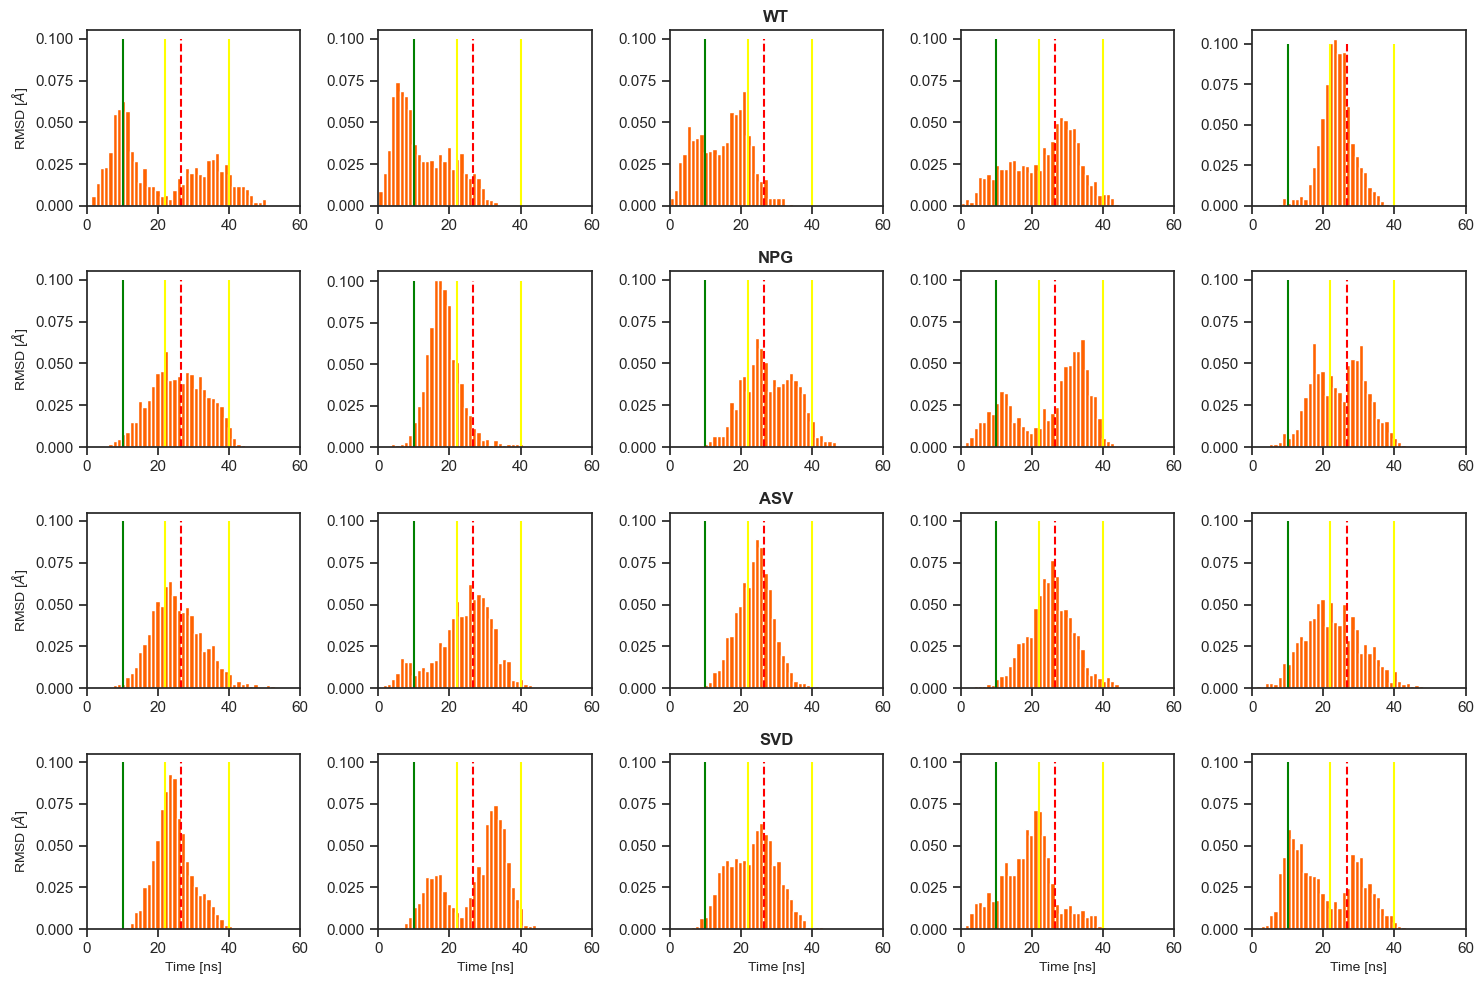

In [16]:
# fold
cols = 5
rows = len(systems)
fig, ax = plt.subplots(rows, cols, figsize=(15, 10))
ax = ax.flatten()

title_spots = [2, 7, 12, 17, 22]
flag = 0
for n in range(cols*rows):
    if n < len(out_data):
        ax[n].hist([x[1] for x in out_data[n]], bins=50, range=(0,60), color='#FF6200', density=True)
        ax[n].vlines(in_state_difference, 0, 0.1, color="red", linestyle="dashed")
        ax[n].vlines(40, 0, 0.1, color="yellow", linestyle="solid")
        ax[n].vlines(22, 0, 0.1, color="yellow", linestyle="solid")
        ax[n].vlines(10, 0, 0.1, color="green")
    
        if n in title_spots:
            ax[n].set_title(f'{systems[flag]}',fontsize=12, weight='bold')
            flag += 1
        if (n+5)%5 == 0:
            ax[n].set_ylabel('RMSD [$\AA$]',fontsize=10)
        if n > (cols*rows-6):
            ax[n].set_xlabel('Time [ns]',fontsize=10)
        
        ax[n].set_xlim(0, 60)
        #ax[n].set_ylim(0, 10)
        #ax[n].set_xlim(-50, len(rmsds[n]))
        #ax[n].spines['right'].set_visible(False)
        #ax[n].spines['top'].set_visible(False)
        
    else: 
        ax[n].remove()
    
plt.tight_layout()

# Correlations between RMSD wrt the In and Out States and Angle

## Correlation Between the RMSD and the Angle Between

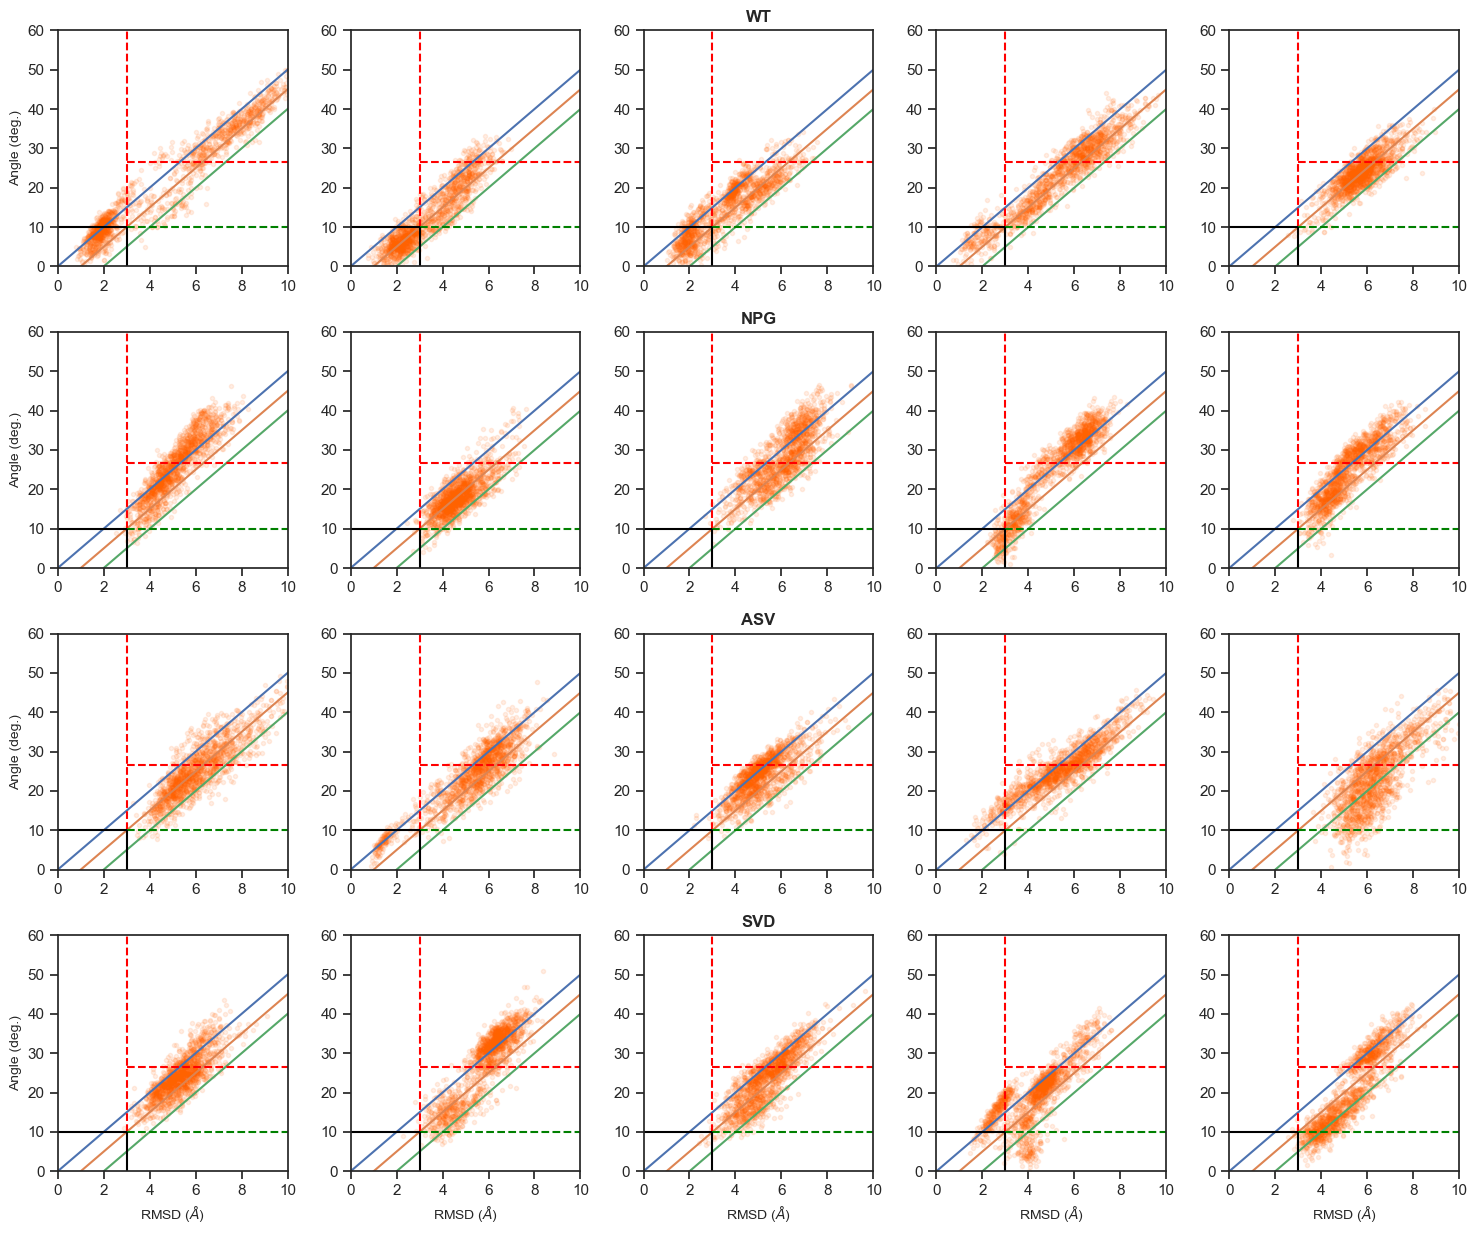

In [17]:
# fold
cols = 5
rows = len(systems)
fig, ax = plt.subplots(rows, cols, figsize=(15, 12.5)) #(15, 12.5)
ax = ax.flatten()

title_spots = [2, 7, 12, 17, 22]
flag = 0
for n in range(cols*rows):
    if n < len(out_data):
        ax[n].plot([x[0] for x in out_data[n]], [y[1] for y in out_data[n]], '.', color='#FF6200', alpha=0.1)
        ax[n].plot([int(x) for x in range(0, 100)], [x*5 for x in range(0, 100)])
        ax[n].plot([int(x) for x in range(0, 100)], [x*5-5 for x in range(0, 100)])
        ax[n].plot([int(x) for x in range(0, 100)], [x*5-10 for x in range(0, 100)])
        ax[n].hlines(in_state_difference, 3, 10,color="red", linestyles="dashed")
        ax[n].vlines(3, 10, 60,color="red", linestyles="dashed")
        ax[n].hlines(10, 0, 3, color="Black")
        ax[n].hlines(10, 3, 10, color="Green", linestyles="dashed")
        ax[n].vlines(3, 0, 10, color="Black")
    
        if n in title_spots:
            ax[n].set_title(f'{systems[flag]}',fontsize=12, weight='bold')
            flag += 1
        if (n+5)%5 == 0:
            ax[n].set_ylabel('Angle (deg.)',fontsize=10)
        if n > (cols*rows-6):
            ax[n].set_xlabel('RMSD ($\AA$)',fontsize=10)
        
        ax[n].set_xlim(0, 10)
        ax[n].set_ylim(0, 60)
        #ax[n].set_xlim(-50, len(out_data[n]))
        #ax[n].spines['right'].set_visible(False)
        #ax[n].spines['top'].set_visible(False)
        
    else: 
        ax[n].remove()
    
plt.tight_layout()

# Summerize the Data as a Bar Plot

Here we summerize the data from the above plots into bar plots.

## RMSD wrt to Out State Data -  Fig 1C, Main Text

In [18]:
# Fold
rmsd_data = []
rmsd_data_err = []
count = 0
for sys in systems:
    #print(sys)
    sys_out = []
    sys_mid = []
    sys_ins = []
    for rep in replicas:
        print(f"{sys} {rep}")
        out = 0
        mid = 0
        ins = 0
        for rmsd in out_data[count]:
            if rmsd[0] < 3:
                out += 1
            elif rmsd[0] < 4.5 and rmsd[0] >= 3:
                mid += 1
            elif rmsd[0] > 6.5: # Updated to place extended state in intermediate state.
                mid += 1
            elif rmsd[0] >= 4.5 and rmsd[0] < 6.5: # Updated to exclude extended state.
                ins += 1
        rep_out = out/len(out_data[count])
        sys_out.append(rep_out)
        rep_mid = mid/len(out_data[count])
        sys_mid.append(rep_mid)
        rep_ins = ins/len(out_data[count])
        sys_ins.append(rep_ins)
        print(f"{rep_out:0.2f} {rep_mid:0.2f} {rep_ins:0.2f}")
        count += 1
    print('----- Mean of Means ----------')
    print(f"{np.mean(sys_out):0.2f} {np.mean(sys_mid):0.2f} {np.mean(sys_ins):0.2f}")
    rmsd_data.append([sys, np.mean(sys_out), np.mean(sys_mid), np.mean(sys_ins)])
    rmsd_data_err.append([sys, np.std(sys_out), np.std(sys_mid), np.std(sys_ins)])
    print('------------------------------')  

WT 1
0.46 0.38 0.16
WT 2
0.50 0.24 0.26
WT 3
0.38 0.35 0.27
WT 4
0.13 0.50 0.37
WT 5
0.00 0.23 0.76
----- Mean of Means ----------
0.30 0.34 0.36
------------------------------
NPG 1
0.00 0.41 0.59
NPG 2
0.00 0.48 0.52
NPG 3
0.00 0.47 0.53
NPG 4
0.10 0.49 0.41
NPG 5
0.00 0.44 0.56
----- Mean of Means ----------
0.02 0.46 0.52
------------------------------
ASV 1
0.00 0.42 0.58
ASV 2
0.10 0.32 0.58
ASV 3
0.00 0.32 0.68
ASV 4
0.08 0.43 0.49
ASV 5
0.00 0.40 0.60
----- Mean of Means ----------
0.04 0.38 0.59
------------------------------
SVD 1
0.00 0.25 0.75
SVD 2
0.00 0.44 0.56
SVD 3
0.01 0.34 0.66
SVD 4
0.19 0.41 0.40
SVD 5
0.01 0.47 0.52
----- Mean of Means ----------
0.04 0.38 0.58
------------------------------


This is the plot used for Figure 1C in the paper.

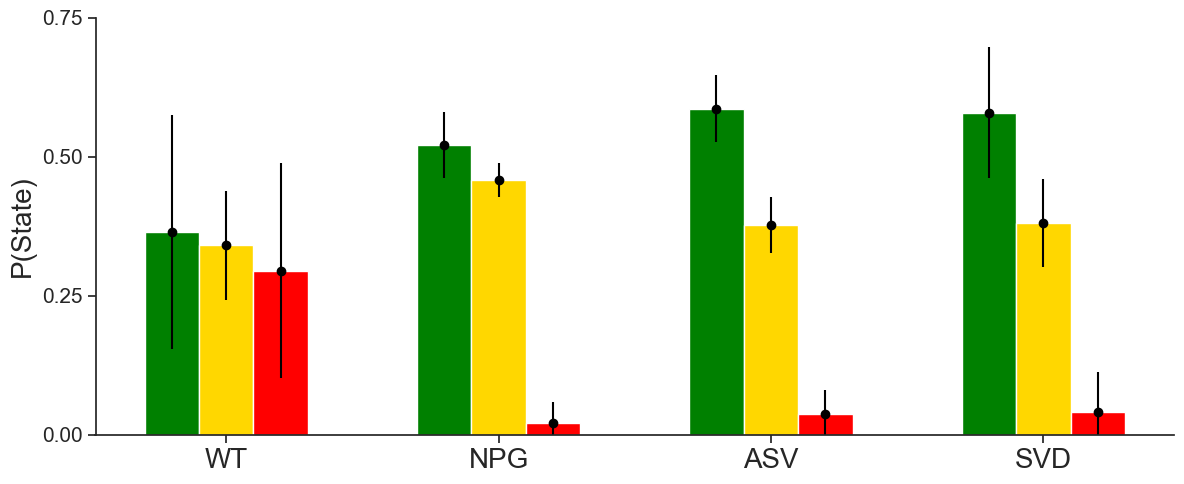

In [19]:
# Fold
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

X = ["WT", "NPG", "ASV", "SVD"]

ins_state = [x[3] for x in rmsd_data]
ins_err = [x[3] for x in rmsd_data_err]
mid_state = [x[2] for x in rmsd_data]
mid_err = [x[2] for x in rmsd_data_err]
out_state = [x[1] for x in rmsd_data]
out_err = [x[1] for x in rmsd_data_err]

X_axis = np.arange(len(X))

ax.bar(X_axis - 0.2, ins_state, 0.2, label = 'In', color = 'Green')
ax.errorbar(X_axis - 0.2, ins_state, yerr=ins_err, fmt="o", color="Black")
ax.bar(X_axis + 0.0, mid_state, 0.2, label = 'Intermediate', color = 'Gold')
ax.errorbar(X_axis - 0.0, mid_state, yerr=mid_err, fmt="o", color="Black")
ax.bar(X_axis + 0.2, out_state, 0.2, label = 'Out', color = 'Red')
ax.errorbar(X_axis + 0.2, out_state, yerr=out_err, fmt="o", color="Black")

ax.set_ylim(0,0.75)
ax.set_ylabel('P(State)',fontsize='20')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.yticks([0.0, 0.25, 0.50, 0.75],fontsize=15)
plt.xticks(X_axis, X,fontsize=20)


#plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('plots/Fig_1C.png',dpi=360, transparent=True)

## Angle between Mobile and Out State Data

In [21]:
# Fold
angle_data = []
angle_data_err = []
count = 0
for sys in systems:
    #print(sys)
    sys_out = []
    sys_mid = []
    sys_ins = []
    for rep in replicas:
        #print(f"{sys} {rep}")
        out = 0
        mid = 0
        ins = 0
        for angle in out_data[count]:
            if angle[1] <= 10:
                out += 1
            elif angle[1] > 10 and angle[1] <= 22:
                mid += 1
            elif angle[1] > 22: # Updated to exclude extended state.
                ins += 1
        rep_out = out/len(out_data[count])
        sys_out.append(rep_out)
        rep_mid = mid/len(out_data[count])
        sys_mid.append(rep_mid)
        rep_ins = ins/len(out_data[count])
        sys_ins.append(rep_ins)
        #print(f"{rep_out:0.2f} {rep_mid:0.2f} {rep_ins:0.2f}")
        count += 1
    #print('----- Mean of Means ----------')
    #print(f"{np.mean(sys_out):0.2f} {np.mean(sys_mid):0.2f} {np.mean(sys_ins):0.2f}")
    angle_data.append([sys, np.mean(sys_out), np.mean(sys_mid), np.mean(sys_ins)])
    angle_data_err.append([sys, np.std(sys_out), np.std(sys_mid), np.std(sys_ins)])
    #print('------------------------------')  

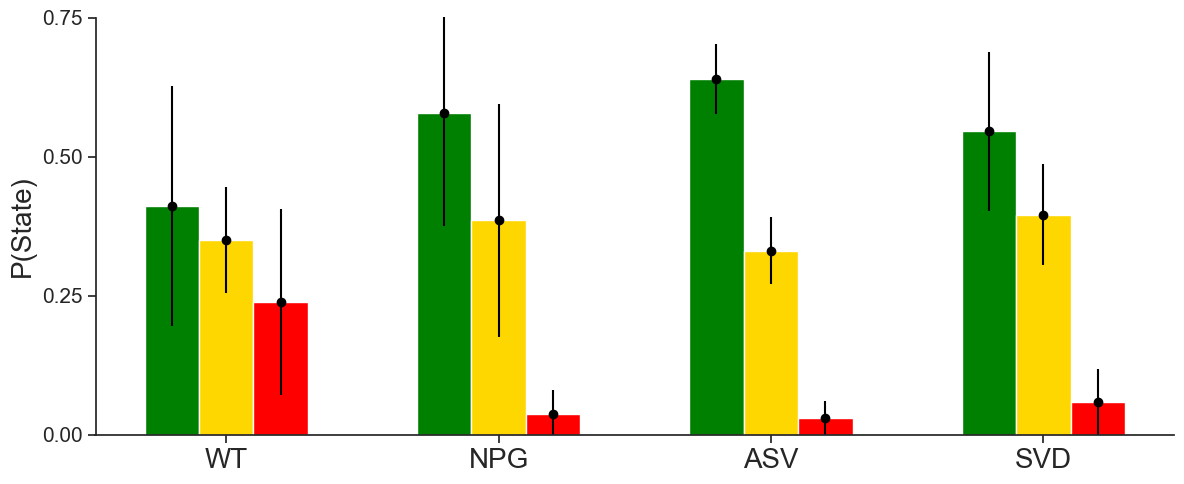

In [22]:
# Fold
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

X = ["WT", "NPG", "ASV", "SVD"]

ins_state = [x[3] for x in angle_data]
ins_err = [x[3] for x in angle_data_err]
mid_state = [x[2] for x in angle_data]
mid_err = [x[2] for x in angle_data_err]
out_state = [x[1] for x in angle_data]
out_err = [x[1] for x in angle_data_err]

X_axis = np.arange(len(X))

ax.bar(X_axis - 0.2, ins_state, 0.2, label = 'In', color = 'Green')
ax.errorbar(X_axis - 0.2, ins_state, yerr=ins_err, fmt="o", color="Black")
ax.bar(X_axis + 0.0, mid_state, 0.2, label = 'Intermediate', color = 'Gold')
ax.errorbar(X_axis - 0.0, mid_state, yerr=mid_err, fmt="o", color="Black")
ax.bar(X_axis + 0.2, out_state, 0.2, label = 'Out', color = 'Red')
ax.errorbar(X_axis + 0.2, out_state, yerr=out_err, fmt="o", color="Black")

ax.set_ylim(0,0.75)
ax.set_ylabel('P(State)',fontsize='20')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.yticks([0.0, 0.25, 0.50, 0.75],fontsize=15)
plt.xticks(X_axis, X,fontsize=20)


plt.tight_layout()